### Notebook for the hands on session 4 (Phonon and thermal conductivity of graphene)

1. **Change directory**

    ```bash
    > cd ../../4_thermal_conductivity_graphene/work
    ```


2. **Create an ANPHON input (phband.in) and run**

    ```
    &general
     PREFIX = graphene
     MODE = phonons
     NKD = 1; KD = C
     FCSXML = graphene_anharm.xml
    /

    &cell
    1.88972612545782819321
        2.44650000000000    0.00000000000000    0.00000000000000
       -1.22325000000000    2.11873115035863    0.00000000000000
        0.00000000000000    0.00000000000000   15.00000000000000
    /

    &kpoint
    1
     G     0.00000000     0.00000000     0.00000000 M     0.50000000     0.00000000     0.00000000   51
     M     0.50000000     0.00000000     0.00000000 K     0.33333333     0.33333333     0.00000000   51
     K     0.33333333     0.33333333     0.00000000 G     0.00000000     0.00000000     0.00000000   51
    /

    &analysis
     GRUNEISEN = 1
    /
    ```
    
    Save the above as `phband.in` and run the code.
    ```sh
    > cp ../../2_force_constant_graphene/work/graphene_anharm.xml .
    > anphon phband.in > phband.log
    ```

In [1]:
import numpy as np
import optparse
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
try:
    mpl.use("Qt5")
except:
    pass
import matplotlib.pyplot as plt

# parser options
usage = "usage: %prog [options] file1.bands file2.bands ... "
parser = optparse.OptionParser(usage=usage)

parser.add_option("--nokey", action="store_false", dest="print_key", default=True,
                  help="don't print the key in the figure")
parser.add_option("-u", "--unit", action="store", type="string", dest="unitname", default="kayser",
                  help="print the band dispersion in units of UNIT. Available options are kayser, meV, and THz", metavar="UNIT")
parser.add_option("--emin", action="store", type="float", dest="emin",
                  help="minimum value of the energy axis")
parser.add_option("--emax", action="store", type="float", dest="emax",
                  help="maximum value of the energy axis")
parser.add_option("--normalize", action="store_true", dest="normalize_xaxis", default=False,
                  help="normalize the x axis to unity.")


# font styles
mpl.rc('font', **{'family': 'Times New Roman', 'sans-serif': ['Helvetica']})
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=16)
mpl.rc('lines', linewidth=1.5)
mpl.rc('legend', fontsize='small')
# line colors and styles
color = ['b', 'g', 'r', 'm', 'k', 'c', 'y', 'r']
lsty = ['-', '-', '-', '-', '--', '--', '--', '--']


def get_kpath_and_kval(file_in):

    ftmp = open(file_in, 'r')
    kpath = ftmp.readline().rstrip('\n').split()
    kval = ftmp.readline().rstrip('\n').split()
    ftmp.close()

    if kpath[0] == '#' and kval[0] == '#':
        kval_float = [float(val) for val in kval[1:]]
        kpath_list = []
        for i in range(len(kpath[1:])):
            if kpath[i + 1] == 'G':
                kpath_list.append('$\Gamma$')
            else:
                kpath_list.append("$\mathrm{%s}$" % kpath[i + 1])

        return kpath_list, kval_float
    else:
        return [], []


def change_scale(array, str_scale):

    str_tmp = str_scale.lower()

    if str_tmp == 'kayser':
        print("Band structure will be shown in units of cm^{-1}")
        return array

    elif str_tmp == 'mev':
        print("Band structure will be shown in units of meV")
        kayser_to_mev = 0.0299792458 * 1.0e+12 * \
            6.62606896e-34 / 1.602176565e-19 * 1000

        for i in range(len(array)):
            for j in range(len(array[i])):
                for k in range(1, len(array[i][j])):
                    array[i][j][k] *= kayser_to_mev

        return array

    elif str_tmp == 'thz':
        print("Band structure will be shown in units of THz")
        kayser_to_thz = 0.0299792458

        for i in range(len(array)):
            for j in range(len(array[i])):
                for k in range(1, len(array[i][j])):
                    array[i][j][k] *= kayser_to_thz

        return array

    else:
        print("Unrecognizable option for --unit %s" % str_scale)
        print("Band structure will be shown in units of cm^{-1}")
        return array


def normalize_to_unity(array, array_axis):

    for i in range(len(array)):
        max_val = array[i][-1][0]

        factor_normalize = 1.0 / max_val

        for j in range(len(array[i])):
            array[i][j][0] *= factor_normalize

    max_val = array_axis[-1]
    factor_normalize = 1.0 / max_val

    for i in range(len(array_axis)):
        array_axis[i] *= factor_normalize

    return array, array_axis


def get_xy_minmax(array):

    xmin, xmax, ymin, ymax = [0, 0, 0, 0]

    for i in range(len(array)):
        xtmp = array[i][-1][0]
        xmax = max(xmax, xtmp)

    for i in range(len(array)):
        for j in range(len(array[i])):
            for k in range(1, len(array[i][j])):
                ytmp = array[i][j][k]
                ymin = min(ymin, ytmp)
                ymax = max(ymax, ytmp)

    return xmin, xmax, ymin, ymax


def gridspec_setup(data_merged, xtickslabels, xticksvars):

    xmaxs = []
    xmins = []

    xticks_grids = []
    xticklabels_grids = []
    xticklabels_tmp = []
    xticks_tmp = []

    for i in range(len(xtickslabels)):

        if i == 0:
            xmins.append(xticksvars[0])
        else:
            if xticksvars[i] == xticksvars[i-1]:
                xmaxs.append(xticksvars[i - 1])
                xmins.append(xticksvars[i])

                xticks_grids.append(xticks_tmp)
                xticklabels_grids.append(xticklabels_tmp)
                xticklabels_tmp = []
                xticks_tmp = []

        xticklabels_tmp.append(xtickslabels[i])
        xticks_tmp.append(xticksvars[i])

    xticks_grids.append(xticks_tmp)
    xticklabels_grids.append(xticklabels_tmp)
    xmaxs.append(xticksvars[-1])

    naxes = len(xticks_grids)
    nfiles = len(data_merged)

    data_all_axes = []

    for i in range(naxes):
        data_ax = []

        xmin_ax = xmins[i]
        xmax_ax = xmaxs[i]

        for j in range(nfiles):

            kval = np.array(data_merged[j][0:, 0])
            ix_xmin_arr = np.where(kval <= xmin_ax)
            ix_xmax_arr = np.where(kval >= xmax_ax)

            if len(ix_xmin_arr[0]) > 0:
                ix_xmin = int(ix_xmin_arr[0][-1])
            else:
                ix_xmin = 0

            if len(ix_xmax_arr[0]) > 0:
                ix_xmax = int(ix_xmax_arr[0][0])
            else:
                ix_xmax = -2

            data_ax.append(data_merged[j][ix_xmin:(ix_xmax+1), :])

        data_all_axes.append(data_ax)

    return naxes, xticks_grids, xticklabels_grids, xmins, xmaxs, data_all_axes


def preprocess_data(files, unitname, normalize_xaxis):

    xtickslabels, xticksvars = get_kpath_and_kval(files[0])

    data_merged = []

    for file in files:
        data_tmp = np.loadtxt(file, dtype=float)
        data_merged.append(data_tmp)

    data_merged = change_scale(data_merged, unitname)

    if normalize_xaxis:
        data_merged, xticksvars = normalize_to_unity(data_merged, xticksvars)

    xmin, xmax, ymin, ymax = get_xy_minmax(data_merged)

    factor = 1.05
    ymin *= factor
    ymax *= factor

    naxes, xticks_grids, xticklabels_grids, xmins, xmaxs, data_merged_grids \
        = gridspec_setup(data_merged, xtickslabels, xticksvars)

    return naxes, xticks_grids, xticklabels_grids, \
        xmins, xmaxs, ymin, ymax, data_merged_grids


def run_plot(nax, xticks_ax, xticklabels_ax, xmin_ax, xmax_ax, ymin, ymax, data_merged_ax, unitname):

    fig = plt.figure()

    width_ratios = []
    for xmin, xmax in zip(xmin_ax, xmax_ax):
        width_ratios.append(xmax - xmin)

    gs = GridSpec(nrows=1, ncols=nax, width_ratios=width_ratios)
    gs.update(wspace=0.1)

    for iax in range(nax):
        ax = plt.subplot(gs[iax])

        for i in range(len(data_merged_ax[iax])):

            if len(data_merged_ax[iax][i]) > 0:
                ax.plot(data_merged_ax[iax][i][0:, 0], data_merged_ax[iax][i][0:, 1],
                        linestyle=lsty[i], color=color[i], label=files[i])

                for j in range(2, len(data_merged_ax[iax][i][0][0:])):
                    ax.plot(data_merged_ax[iax][i][0:, 0], data_merged_ax[iax][i][0:, j],
                            linestyle=lsty[i], color=color[i])

        if iax == 0:
            if unitname.lower() == "mev":
                ax.set_ylabel("Frequency (meV)", labelpad=20)
            elif unitname.lower() == "thz":
                ax.set_ylabel("Frequency (THz)", labelpad=20)
            else:
                ax.set_ylabel("Frequency (cm${}^{-1}$)", labelpad=10)

        else:
            ax.set_yticklabels([])
            ax.set_yticks([])

        plt.axis([xmin_ax[iax], xmax_ax[iax], ymin, ymax])
        ax.set_xticks(xticks_ax[iax])
        ax.set_xticklabels(xticklabels_ax[iax])
        ax.xaxis.grid(True, linestyle='-')

        
        ax.legend(loc='best', prop={'size': 10})

    plt.show()

Band structure will be shown in units of meV


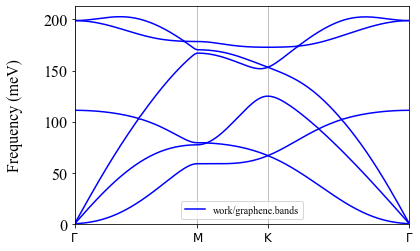

In [2]:
# Draw phonon dispersion curve
files = ['work/graphene.bands']
unitname = 'meV' # 'THz' or 'kayser'
normalize_xaxis = False

nax, xticks_ax, xticklabels_ax, xmin_ax, xmax_ax, ymin, ymax, data_merged_ax \
    = preprocess_data(files,unitname, normalize_xaxis)

run_plot(nax, xticks_ax, xticklabels_ax,
         xmin_ax, xmax_ax, ymin, ymax, data_merged_ax, unitname)

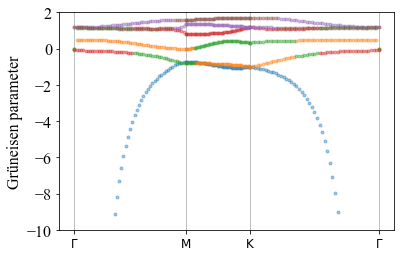

In [29]:
data = np.loadtxt('work/graphene.gruneisen')
kpath, kval = get_kpath_and_kval('work/graphene.bands')

ax = plt.subplot(111)

ax.plot(data[:,0], data[:,1:], linestyle='None', marker='o', alpha=0.4, ms=3)

ax.set_ylim(-10,2)
ax.set_xticks(kval)
ax.set_xticklabels(kpath)
ax.xaxis.grid(True, linestyle='-')
ax.set_ylabel(r"Grüneisen parameter")

plt.show()

3. **Compute phonon DOS**
    
    ```sh
    > cp phband.in phdos.in
    (edit phdos.in)
    > anphon phdos.in > phdos.log
    ```
    <br>

    In `phdos.in`, the following part should be modified:
    
    ```
    &general
     PREFIX = graphene
     MODE = phonons
     NKD = 1; KD = C
     FCSXML = graphene_anharm.xml
     EMIN = 0; EMAX = 2000; DELTA_E = 1
     TMIN = 0; TMAX = 2000; DT = 10
    /

    &cell
    1.88972612545782819321
        2.44650000000000    0.00000000000000    0.00000000000000
       -1.22325000000000    2.11873115035863    0.00000000000000
        0.00000000000000    0.00000000000000   15.00000000000000
    /

    &kpoint
    2
    20 20 1
    /

    &analysis
     PRINTMSD = 1
    /
    ```

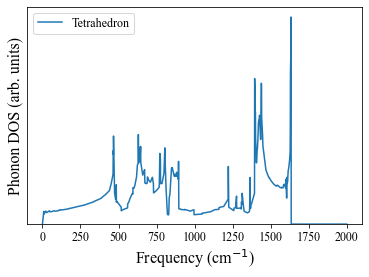

In [3]:
ax = plt.subplot(111)

data = np.loadtxt('work/graphene.dos')
ax.plot(data[:,0], data[:,1], linestyle='-', marker='None', label='Tetrahedron')

ax.set_ylim(0)
ax.set_yticks([])
ax.set_xlabel(r"Frequency (cm$^{-1}$)")
ax.set_ylabel(r"Phonon DOS (arb. units)")

ax.legend(loc='best', fontsize=12)

plt.show()


In [1]:
# Plot thermodynamic functions
import pandas as pd

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=2)
gs.update(wspace=0.35, hspace=0.3)

data = pd.read_csv('work/graphene.thermo', comment='#', 
                   header=None, 
                   delim_whitespace=True,
                   names=['Temperature (K)', '$C_v/k_B$', '$S/k_B$', '$U_{vib}$ [Ry]', '$F_{vib}$ [Ry]'])

for iax in range(4):
    ax = plt.subplot(gs[iax])
    data.plot(x=0, y=iax+1, ax=ax, legend=False)
    ax.set_xlim(0)
    if iax < 3:
        ax.set_ylim(0)
    ax.set_ylabel(data.columns[iax+1])

plt.savefig('thermodynamic.pdf', bbox_inches='tight')    
plt.show()


NameError: name 'plt' is not defined

4. **Compute mean square displacement and plot**

    Add `&analysis` option in `phdos.in` and set `PRINTMSD = 1` in the `&analysis` field.
    
    ```sh
    > anphon phdos.in > phdos.log
    > less Si.msd
    ```

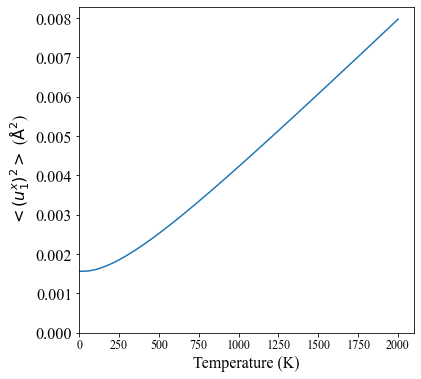

In [5]:
fig = plt.figure(figsize=(6, 6))

data = pd.read_csv('work/graphene.msd', comment='#', 
                   header=None, 
                   delim_whitespace=True,
                   names=['Temperature (K)', '$<(u_{1}^{x})^{2}>$'],
                   usecols=[0,1])

ax = plt.subplot(111)
data.plot(x=0, y=1, ax=ax, legend=False)
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_ylabel("%s ($\mathrm{\AA}^2$)" % data.columns[1])

plt.savefig('msd.pdf', bbox_inches='tight')    
plt.show()

5. **Compute thermal conductivity and plot result**

    ```sh
    > cp phdos.in kappa.in

    ```
    <br>

    - Please edit `kappa.in` as follows:
    
        ```
        &general
         PREFIX = graphene
         MODE = RTA
         NKD = 1; KD = C
         FCSXML = graphene_anharm.xml
         EMIN = 0; EMAX = 2000; DELTA_E = 1
         TMIN = 0; TMAX = 2000; DT = 10
        /

        &cell
        1.88972612545782819321
            2.44650000000000    0.00000000000000    0.00000000000000
           -1.22325000000000    2.11873115035863    0.00000000000000
            0.00000000000000    0.00000000000000   15.00000000000000
        /

        &kpoint
        2
        20 20 1
        /

        &analysis
         KAPPA_SPEC = 1
        /

        ```
    <br>
    
    - Run ANPHON using mpirun:
    
    ```sh
    > mpirun -np 4 anphon kappa.in > kappa.log
    ```


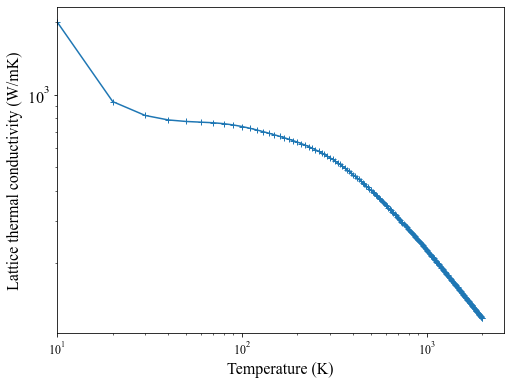

In [8]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

data = np.loadtxt('work/graphene.kl')
thickness_graphene = 3.35 # angstrom
factor = 15.0 / thickness_graphene
ax.plot(data[:,0], data[:,1] * factor, marker='+', linestyle='-', label='pure')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Lattice thermal conductivity (W/mK)")
plt.savefig('kappa.pdf', bbox_inches='tight')

6. **Compute thermal conductivity with phonon-boundary scattering**

    ```sh
    > python -m analyze_phonons --calc kappa_boundary --size 1.0e+5 graphene.result > graphene_boundary.kl
    ```

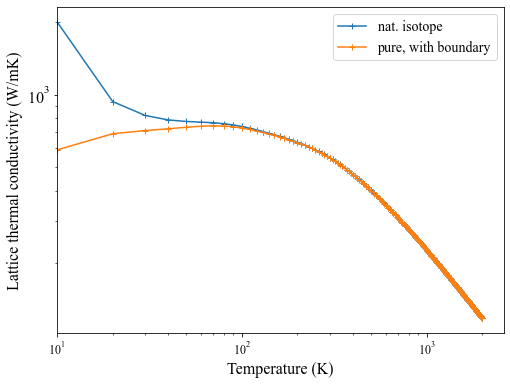

In [14]:
# Plot kappa with boundary scattering
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
thickness_graphene = 3.35 # angstrom
factor = 15.0 / thickness_graphene

data = np.loadtxt('work/graphene.kl')
ax.plot(data[:,0], data[:,1] * factor, marker='+', linestyle='-', label='pure')
data = np.loadtxt('work/graphene_boundary.kl')
ax.plot(data[:,0], data[:,1] * factor, marker='+', linestyle='-', label='pure, with boundary')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=14)
ax.set_xlim(10)
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Lattice thermal conductivity (W/mK)")
plt.savefig('kappa3.pdf', bbox_inches='tight')

7. **Lattice thermal conductivity spectrum**

    In the `&analysis` field of `kappa.in`, please add `KAPPA_SPEC = 1` and comment out `ISOTOPE` as
    
    ```
    &analysis
     KAPPA_SPEC = 1
     #ISOTOPE = 2
    /
    ```
    <br>

    Also, set the energy sampling grid in `&general` field as
    
    ```
     EMIN = 0; EMAX = 550; DELTA_E = 1
    ```
    <br>

    Run ANPHON again:
    
    ```sh
    > anphon kappa.in
    > less graphene.kl_spec
    ```    

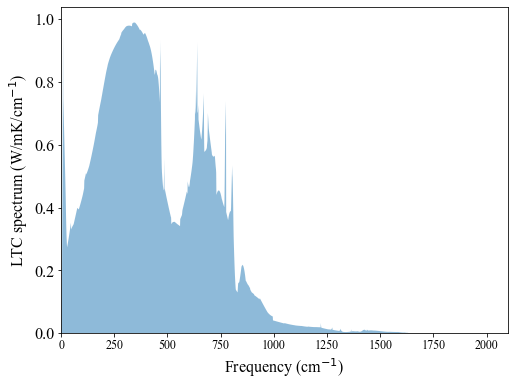

In [15]:
# Plot kappa with boundary scattering
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

data = np.loadtxt('work/graphene.kl_spec')
temperature = 300
data_sub = data[np.where(data[:,0]==temperature)]

thickness_graphene = 3.35 # angstrom
factor = 15.0 / thickness_graphene

ax.fill_between(data_sub[:,1], data_sub[:,2] * factor,  linestyle='-', alpha=0.5)
ax.set_ylim(0)
ax.set_xlim(0)
ax.set_xlabel("Frequency (cm$^{-1}$)")
ax.set_ylabel("LTC spectrum (W/mK/cm$^{-1}$)")
plt.savefig('kappa_spec.pdf', bbox_inches='tight')

9. **Compute lifetime, mean-free-path and plot**

    ```sh
    > python -m analyze_phonons --calc tau --temp 300 graphene.result > tau_300K.dat
    ```

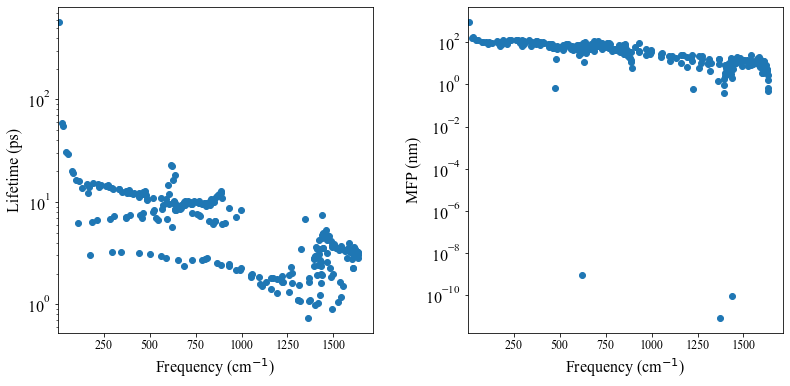

In [11]:
# Plot thermodynamic functions
import pandas as pd

fig = plt.figure(figsize=(13, 6))
gs = GridSpec(nrows=1, ncols=2)
gs.update(wspace=0.3, hspace=0.3)

data = pd.read_csv('work/tau_300K.dat', comment='#', 
                   header=None, 
                   delim_whitespace=True,
                   names=['ik', 'is', 'Frequency (cm$^{-1}$)', 'Lifetime (ps)', 'MFP (nm)'],
                   usecols=[0, 1, 2, 3, 5])

for iax in range(2):
    ax = plt.subplot(gs[iax])
    data.plot(x=2, y=iax+3, ax=ax, legend=False, linestyle='None', marker='o')
    ax.set_xlim(0.1)
    ax.set_yscale('log')
    ax.set_ylabel(data.columns[iax+3])

plt.show()

10. **Cumulative thermal conductivity**

    ```sh
    > python -m analyze_phonons --calc cumulative --temp 300 --length 10000:1 graphene.result > graphene.kl_cumulative
    ```

Text(0, 0.5, 'Cumulative LTC (W/mK)')

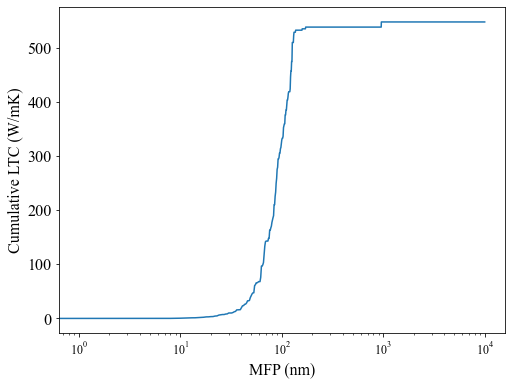

In [17]:
# Plot kappa with boundary scattering
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)

thickness_graphene = 3.35 # angstrom
factor = 15.0 / thickness_graphene

data = np.loadtxt('work/graphene.kl_cumulative', usecols=[0, 1])
ax.plot(data[:,0], data[:,1] * factor,  linestyle='-')
ax.set_xscale('log')
ax.set_xlabel("MFP (nm)")
ax.set_ylabel("Cumulative LTC (W/mK)")
